[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/tutorials/wikipedia/sdm.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/tutorials/wikipedia/sdm.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/tutorials/wikipedia/sdm.ipynb)

#### developed for the Wikipedia article on SDM

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

### "pseudocode" (i.e., valid Python) implementation of SDM

In [2]:
import numpy as np
from collections import abc

def sdm(*,
    rng: np.random.Generator,
    mult: abc.MutableSequence[int],
    mass: abc.MutableSequence[float],
    kern: abc.Callable[[float, float], float],
    dt: float,
    dv: float,
):
    """ Monte-Carlo coagulation step using SDM algorithm assuming non-zero multiplicities """
    n_parts = len(mult)
    n_pairs = n_parts // 2

    pairs = rng.permutation(n_parts)[: 2 * n_pairs].reshape(-1, 2)
    u01 = rng.uniform(0, 1, n_pairs)

    p_scale = n_parts * (n_parts - 1) / 2 / n_pairs
    for alpha, (j, k) in enumerate(pairs):
        if mult[j] < mult[k]:
            j, k = k, j
        p_alpha = mult[j] * p_scale * kern(mass[j], mass[k]) * dt / dv
        gamma = p_alpha // 1 + (p_alpha - p_alpha // 1) > u01[alpha]
        if gamma != 0:
            gamma = min(gamma, (mult[j] / mult[k]) // 1)
            if mult[j] - gamma * mult[k] > 0:
                mult[j] -= gamma * mult[k]
                mass[k] += gamma * mass[j]
            else:
                mult[j] = mult[k] // 2
                mult[k] -= mult[j]
                mass[k] += gamma * mass[j]
                mass[j] = mass[k]

### definition of the additive collision kernel and the Golovin's analytic solution

In [3]:
from scipy import special

def golovin_analytic_solution(mass, time, x0, b, n0):
    """ [Golovin's analytic solution](http://mi.mathnet.ru/dan27630) 
    to Smoluchowski coagulation equation for additive kernel
    and exponential initial condition """
    tau = 1 - np.exp(-n0 * x0 * b * time)
    sqrt_tau = np.sqrt(tau)
    return (
        (1 - tau) / (mass * sqrt_tau)
        * special.ive(1, 2 * mass / x0 * sqrt_tau)  # pylint: disable=no-member
        * np.exp(-(1 + tau - 2 * sqrt_tau) * mass / x0)
    )

def additive_kernel(mass_1, mass_2, coeff):
    """ additive coagulation kernel """
    return coeff * (mass_1 + mass_2)

### simulation prameters inspired by Fig. 2 from [Shima et al. 2009](https://doi.org/10.1002/qj.441)

In [4]:
from types import SimpleNamespace
from scipy import stats

PARAMS_PHYS = SimpleNamespace(
    n0 = 2**23,
    dv = 1e6,
    b = 1.5e3,
)
PARAMS_PHYS.norm = PARAMS_PHYS.n0 * PARAMS_PHYS.dv
PARAMS_PHYS.dist = stats.expon(loc=0, scale=1 / PARAMS_PHYS.norm)

PARAMS_COMP = SimpleNamespace(
    n_part = 2**11,
    dt = 1,
    n_step = 3600,
    output_step = 100,
)

PARAMS_PLOT = SimpleNamespace(
    x_of_mass = lambda mass: np.log(mass) / 3,
    mass_of_x = lambda x: np.exp(3 * x),
    bins_x_range = (-12, -5),
    bins_count = 35,
)

RNG = np.random.default_rng(seed=123)

### simulation loop

In [5]:
from functools import partial
from copy import deepcopy

def simulate(*, params_phys, params_comp, rng):
    """ does simulation for all sampling variants (each variant using the same shuffled numbers) """
    particles = np.empty(params_comp.n_part, dtype=[('mult', int), ('mass', float)])
    particles['mult'] =  np.round(params_phys.norm / params_comp.n_part)
    particles['mass'] =  params_phys.dist.ppf(rng.uniform(0, 1, params_comp.n_part))

    kern = partial(additive_kernel, coeff=params_phys.b)
    output = []
    for step in range(params_comp.n_step + 1):
        if step != 0:
            sdm(
                rng=rng,
                kern=kern,
                dt=params_comp.dt,
                dv=params_phys.dv,
                mass=particles['mass'],
                mult=particles['mult'],
            )
        output += [deepcopy(particles) if step % params_comp.output_step == 0 else None]
    return output
OUTPUT = simulate(params_phys=PARAMS_PHYS, params_comp=PARAMS_COMP, rng=RNG)

### ensuring that the assumption of non-zero multiplicities was valid till the end of the simulation

In [6]:
assert all(OUTPUT[-1]['mult'] > 0)

### animation generation

In [7]:
from matplotlib import pyplot

def plot(step, *, output, params_phys, params_comp, params_plot, positions):
    """ plots the particle state as both a histogram as well as population scatter plot
    (with random coordinates shuffled for the purpose of plotting) """
    time = 1e-10 if step == 0 else step * params_comp.dt
    particles = output[step]
    fig, axs = pyplot.subplot_mosaic(
        [['hist'], ['part']],
        figsize=(3, 5),
        sharex=True,
        layout='constrained',
    )
    axs['hist'].hist(
        x=params_plot.x_of_mass(particles['mass']),
        weights=particles['mult'] / params_phys.norm * particles['mass'],
        bins=params_plot.bins_count,
        range=params_plot.bins_x_range,
        label="SDM",
        density=True,
    )
    points = axs['part'].scatter(
        params_plot.x_of_mass(particles['mass']),
        positions,
        c=np.log2(particles['mult']),
        s=3
    )
    points.set_clim(10, np.log2(params_phys.norm / params_comp.n_part))

    lin_x, d_x = np.linspace(*params_plot.bins_x_range, 256, retstep=True)
    x_mean = lin_x[:-1] + d_x / 2
    m_mean = params_plot.mass_of_x(x_mean)

    axs['hist'].plot(
        x_mean,
        m_mean * params_phys.norm * golovin_analytic_solution(
            mass=m_mean,
            time=time,
            x0=1/params_phys.norm,
            n0=params_phys.n0,
            b=params_phys.b
        ) * np.diff(params_plot.mass_of_x(lin_x)) / np.diff(lin_x),
        color='black',
        label='analytic',
        ls='--'
    )
    axs['hist'].legend()
    axs['hist'].set_ylim(0, 1.5)
    axs['hist'].set_yticks([])
    axs['hist'].set_ylabel(r'pdf(x) $\cdot$ mass(x)')
    axs['hist'].set_title(f'time: {time:.0f} s')
    axs['hist'].set_xlim(*params_plot.bins_x_range)
    axs['hist'].spines['top'].set_visible(False)
    axs['hist'].spines['right'].set_visible(False)
    axs['hist'].plot(1, 0, ">k", transform=axs['hist'].get_yaxis_transform(), clip_on=False)
    axs['hist'].plot(params_plot.bins_x_range[0], 1.5, "^k", clip_on=False)
    axs['part'].set_xlabel(r'$x = \ln(\sqrt[3]{\text{mass/kg}})$')
    axs['part'].set_yticks([])
    axs['part'].set_ylabel('auxiliary particle attribute')
    axs['part'].set_ylim(0, 1)
    axs['part'].grid()
    fig.colorbar(points, label='log$_2$(multiplicity)')
    return fig


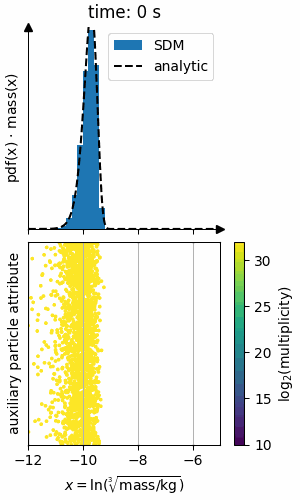

HTML(value="<a href='./super_droplet_method_teaser.gif' target='_blank'>./super_droplet_method_teaser.gif</a><…

In [8]:
from open_atmos_jupyter_utils import show_anim

show_anim(
    partial(
        plot,
        output=OUTPUT,
        params_phys=PARAMS_PHYS,
        params_comp=PARAMS_COMP,
        params_plot=PARAMS_PLOT,
        positions=RNG.uniform(0, 1, PARAMS_COMP.n_part),
    ),
    frame_range=range(0, len(OUTPUT), PARAMS_COMP.output_step),
    gif_file='super_droplet_method_teaser.gif'
)